# Part 1: Sentiment Analysis

In [ ]:
import pandas as pd

# Load the CSV file
file_path = './data/NEWS_YAHOO_stock_prediction.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

In [ ]:
# Step 1: Remove unnecessary column
data.drop(columns=['Unnamed: 0'], inplace=True)

# Step 2: Remove duplicate texts
data.drop_duplicates(subset=['title', 'content'], inplace=True)

# Step 3: Remove rows with large amount of spaces or empty texts in 'title' and 'content'
data = data[~data['title'].str.isspace()]
data = data[~data['content'].str.isspace()]
data.dropna(subset=['title', 'content'], inplace=True)

# Check the dataframe after these preprocessing steps
data.info()

# Step 5: Check for invalid numeric data
numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
data[numeric_columns].describe()


In [ ]:
# (optional) set proxy
import subprocess
import os

result = subprocess.run('bash -c "source ~/clash_dir/set && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
output
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import pipeline

# Load the FinBERT model and tokenizer
checkpoint = 'yiyanghkust/finbert-tone'
tokenizer = BertTokenizer.from_pretrained(checkpoint)
model = BertForSequenceClassification.from_pretrained(checkpoint, num_labels=3)

# Create a pipeline for sentiment analysis
nlp = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, max_length=512, truncation=True, device=0)

In [ ]:
# Function to apply sentiment analysis to a dataframe
def apply_sentiment_analysis(df, nlp, text_column='content'):
    """
    Apply sentiment analysis to a column in a dataframe.
    
    Args:
    df (pd.DataFrame): Dataframe containing the text data.
    nlp (pipeline): HuggingFace pipeline for sentiment analysis.
    text_column (str): Name of the column containing text data.

    Returns:
    pd.DataFrame: Dataframe with a new column 'sentiment' containing the analysis results.
    """
    # Apply sentiment analysis to each row in the text column
    sentiments = []
    for text in df[text_column]:
        try:
            result = nlp(text)
            sentiments.append(result[0]['label'])
        except Exception as e:
            print(f"Error in processing text: {e}")
            sentiments.append('Error')

    # Add the sentiments as a new column in the dataframe
    df['sentiment'] = sentiments
    return df


In [ ]:
from tqdm.auto import tqdm
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def apply_sentiment_analysis_parallel(df, nlp, text_column='content', batch_size=10):
    """
    Apply sentiment analysis in parallel to a column in a dataframe.

    Args:
    df (pd.DataFrame): Dataframe containing the text data.
    nlp (pipeline): HuggingFace pipeline for sentiment analysis.
    text_column (str): Name of the column containing text data.
    batch_size (int): Number of texts to process in parallel.

    Returns:
    pd.DataFrame: Dataframe with a new column 'sentiment' containing the analysis results.
    """
    # Define a function to process a batch of texts
    def process_batch(texts):
        return [nlp(text)[0]['label'] for text in texts]

    # Break the texts into batches
    batches = [df[text_column][i:i + batch_size] for i in range(0, len(df), batch_size)]

    # Process batches in parallel
    sentiments = []
    with ThreadPoolExecutor() as executor:
        for batch_result in tqdm(executor.map(process_batch, batches), total=len(batches)):
            sentiments.extend(batch_result)

    # Add the sentiments as a new column in the dataframe
    df['sentiment'] = sentiments
    return df


In [ ]:
# Example usage of the function
# Note: You will run this on your local machine as it requires GPU support
sample_texts = ["I've been waiting for a HuggingFace course my whole life.", "So have I!"]
sample_df = pd.DataFrame(sample_texts, columns=['content'])
apply_sentiment_analysis(sample_df, nlp)

In [ ]:
# Assuming the apply_sentiment_analysis function is defined as shown previously

# Step 1: Apply sentiment analysis to the dataset
# This step should be done on your local machine due to the requirement of GPU support
data = apply_sentiment_analysis_parallel(data, nlp)

# Step 2: Prepare data for the prediction model
# Here we'll assume the sentiment analysis has been applied and 'sentiment' column is added to the data

# We might want to convert sentiments to numerical values for model training
sentiment_mapping = {'Positive': 1, 'Neutral': 0, 'Negative': -1}
data['sentiment_numeric'] = data['sentiment'].map(sentiment_mapping)

In [ ]:
# Example code to save the processed DataFrame to a CSV file
data.to_csv('./data/dataset_with_sentiment.csv', index=False)


In [ ]:
# Adjust display settings for better visualization of samples
pd.set_option('display.max_colwidth', 200)  # Adjust the width to fit longer texts

# Display some random samples with formatted output
sample_data = data.sample(n=10)[['content', 'sentiment']]

# Print each sample in a more readable format
for index, row in sample_data.iterrows():
    print(f"Sample {index}:")
    print(f"Content: {row['content']}")
    print(f"Sentiment: {row['sentiment']}\n")


In [ ]:
# Assuming 'data' is your DataFrame with 'sentiment' and 'label' columns
# Calculate the proportion of each sentiment category
sentiment_counts = data['sentiment'].value_counts(normalize=True) * 100

# Calculate the proportion of each label
label_counts = data['label'].value_counts(normalize=True) * 100

# Print the results
print("Sentiment Distribution (%):")
print(sentiment_counts)
print("\nLabel Distribution (%):")
print(label_counts)

# For additional insights, we can also look at the cross-tabulation of sentiment and label
crosstab = pd.crosstab(data['sentiment'], data['label'], normalize='index') * 100
print("\nCross-Tabulation of Sentiment and Label (%):")
print(crosstab)

In [72]:
# read for existed csv
import pandas as pd
data = pd.read_csv('./data/dataset_with_sentiment.csv')

# Convert the 'Date' column to datetime format and sort the dataframe by 'Date'
data['Date'] = pd.to_datetime(data['Date'])
data_sorted = data.sort_values(by='Date')

In [73]:
# 按 'Date' 和 'sentiment' 分组，然后计算每个类别的 category 为news和opinion的数量
category_news_per_day_sentiment = data_sorted[data_sorted['category'] == 'news'].groupby(['Date', 'sentiment']).size().unstack().fillna(0)
category_opinion_per_day_sentiment = data_sorted[data_sorted['category'] == 'opinion'].groupby(['Date', 'sentiment']).size().unstack().fillna(0)
# 分别计算news和opinion的total
category_news_total_per_day_sentiment = data_sorted[data_sorted['category'] == 'news'].groupby(['Date']).size()
category_opinion_total_per_day_sentiment = data_sorted[data_sorted['category'] == 'opinion'].groupby(['Date']).size()

data_sorted = data_sorted.set_index('Date')
data_sorted['P_news_pos'] = category_news_per_day_sentiment['Positive'].reindex(data_sorted.index) / category_news_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_news_neg'] = category_news_per_day_sentiment['Negative'].reindex(data_sorted.index) / category_news_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_op_pos'] = category_opinion_per_day_sentiment['Positive'].reindex(data_sorted.index) / category_opinion_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted['P_op_neg'] = category_opinion_per_day_sentiment['Negative'].reindex(data_sorted.index) / category_opinion_total_per_day_sentiment.reindex(data_sorted.index)
data_sorted = data_sorted.reset_index()

In [74]:
daily_data = data_sorted.groupby('Date').last()

# Shift the 'Open' column to get the next day's opening price
daily_data['Next_Open'] = daily_data['Open'].shift(-1)

# Drop the last row as it will not have a 'Next_Open' value
daily_data = daily_data[:-1]

In [75]:
date_to_query = pd.to_datetime('2016-10-28')
daily_data.loc[(date_to_query)]

ticker                                                            AAPL
category                                                       opinion
title                   Dollar Sidelined  Krona Stabilizes  Rates Firm
content              The main development here in the last full wee...
Open                                                         28.467501
High                                                           28.8025
Low                                                          28.362499
Close                                                            28.43
Adj Close                                                    26.514231
Volume                                                       151446800
label                                                                0
sentiment                                                      Neutral
sentiment_numeric                                                    0
P_news_pos                                                         0.0
P_news

In [76]:
date_to_query = pd.to_datetime('2016-10-28')
data_sorted.loc[data_sorted['Date'] == date_to_query]

,Date,ticker,category,title,content,Open,High,Low,Close,Adj Close,Volume,label,sentiment,sentiment_numeric,P_news_pos,P_news_neg,P_op_pos,P_op_neg
3891,2016-10-28,AAPL,opinion,Tech Earnings Roundup Amazon Alphabet Apple...,On this special short earnings edition of the...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Positive,1,0.0,0.0,0.5,0.125
3892,2016-10-28,AAPL,opinion,Videogame Stock Roundup Earnings In Focus Ac...,Earnings reports were in the limelight this we...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Negative,-1,0.0,0.0,0.5,0.125
3893,2016-10-28,AAPL,opinion,Netflix And Amazon Video Absent From Apple s N...,During Apple Inc s NASDAQ AAPL recent Mac...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Neutral,0,0.0,0.0,0.5,0.125
3894,2016-10-28,AAPL,opinion,Top Ranked ETFs To Buy On Alphabet s Robust Q3...,Google s parent company Alphabet Inc s NASD...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Positive,1,0.0,0.0,0.5,0.125
3895,2016-10-28,AAPL,opinion,The Zacks Stocks In The News Blog Highlights ...,For Immediate Release\nChicago IL October 28 ...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Positive,1,0.0,0.0,0.5,0.125
3896,2016-10-28,AAPL,news,Amazon targets Chinese demand for overseas sho...,BEIJING Reuters Amazon com Inc NASDAQ AMZ...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Neutral,0,0.0,0.0,0.5,0.125
3897,2016-10-28,AAPL,opinion,An End To The Earnings Recession,The growth picture emerging from the Q3 earnin...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Positive,1,0.0,0.0,0.5,0.125
3898,2016-10-28,AAPL,opinion,Is Apple s Stock Cheap Not To My Eyes,Apple NASDAQ AAPL reported earnings this wee...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Neutral,0,0.0,0.0,0.5,0.125
3899,2016-10-28,AAPL,opinion,Dollar Sidelined Krona Stabilizes Rates Firm,The main development here in the last full wee...,28.467501,28.8025,28.362499,28.43,26.514231,151446800,0,Neutral,0,0.0,0.0,0.5,0.125


In [77]:
date_to_query = pd.to_datetime('2020-01-23')
daily_data.loc[(date_to_query)]

ticker                                                            AAPL
category                                                          news
title                Apple Boosts Chip Orders From Main Foundry Sup...
content              Apple s  NASDAQ AAPL  iPhone 11 has been selli...
Open                                                         79.480003
High                                                         79.889999
Low                                                          78.912498
Close                                                        79.807503
Adj Close                                                    78.315315
Volume                                                       104472000
label                                                                1
sentiment                                                     Positive
sentiment_numeric                                                    1
P_news_pos                                                    0.461538
P_news

In [78]:
date_to_query = pd.to_datetime('2018-05-06')
category_to_query = 'news'
data_sorted.loc[(data_sorted['Date'] == date_to_query) & (data_sorted['category'] == category_to_query)]

,Date,ticker,category,title,content,Open,High,Low,Close,Adj Close,Volume,label,sentiment,sentiment_numeric,P_news_pos,P_news_neg,P_op_pos,P_op_neg
9679,2018-05-06,AAPL,news,Apple and Buffett saw value and acted,By Noel Randewich SAN FRANCISCO Reuters Ap...,48.267502,48.485001,48.09,48.327499,46.396736,86264000,1,Neutral,0,0.0,0.0,0.814815,0.12963
9680,2018-05-06,AAPL,news,Buffett craves more Apple shares endorses its...,By Trevor Hunnicutt and Jonathan Stempel OMAHA...,48.267502,48.485001,48.09,48.327499,46.396736,86264000,1,Neutral,0,0.0,0.0,0.814815,0.12963


In [79]:
daily_data['P_news_neg'].fillna(0, inplace=True)
daily_data['P_news_pos'].fillna(0, inplace=True)
daily_data['P_op_neg'].fillna(0, inplace=True)
daily_data['P_op_pos'].fillna(0, inplace=True)

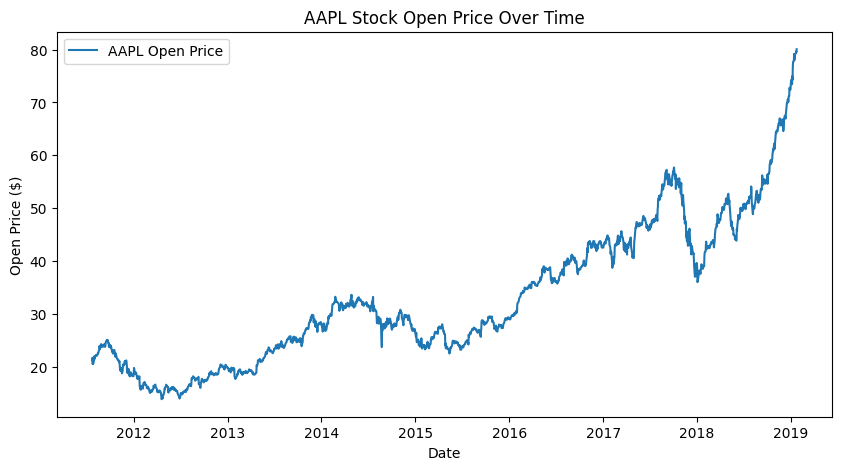

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the dataset into a Pandas DataFrame
historical_data = pd.read_csv('data/AAPL_Yahoo_Correct.csv')

# Convert the 'Date' column to datetime format
historical_data['Date'] = pd.to_datetime(historical_data['Date'])

# Plotting the 'Open' price against the 'Date'
plt.figure(figsize=(10, 5))
plt.plot(historical_data['Date'], historical_data['Open'], label='AAPL Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price ($)')
plt.title('AAPL Stock Open Price Over Time')
plt.legend()
plt.show()


In [135]:
# 按照Date将historical_data的全部列和daily_data的这四个P_开头的列合并。如果出现有些天在daily_data中不存在，则四个P_开头的列在这一天都置为0。
daily_data_BERT = pd.merge(historical_data, daily_data[['P_news_neg', 'P_news_pos', 'P_op_neg', 'P_op_pos']], left_on='Date', right_index=True, how='left')
daily_data_BERT[['P_news_neg', 'P_news_pos', 'P_op_neg', 'P_op_pos']] = daily_data_BERT[['P_news_neg', 'P_news_pos', 'P_op_neg', 'P_op_pos']].fillna(0)


In [136]:
daily_data_BERT.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,P_news_neg,P_news_pos,P_op_neg,P_op_pos
0,2012-07-23,21.228571,21.639286,20.989643,21.565357,18.280512,487975600,0.0,0.0,0.333333,0.333333
1,2012-07-24,21.692142,21.774286,21.375357,21.461430,18.192419,565132400,0.0,0.0,0.000000,0.000000
2,2012-07-25,20.516430,20.742857,20.357143,20.534643,17.406801,877312800,0.0,0.0,0.000000,0.000000
3,2012-07-26,20.705713,20.728571,20.370001,20.531429,17.404078,406632800,0.0,0.0,0.000000,0.000000
4,2012-07-27,20.536072,20.922501,20.413929,20.898571,17.715296,403936400,0.0,0.0,1.000000,0.000000
5,2012-07-30,21.104286,21.408571,20.993570,21.251072,18.014109,379142400,0.0,0.0,1.000000,0.000000
6,2012-07-31,21.543928,21.846430,21.525715,21.812857,18.490314,462327600,0.0,0.0,0.000000,0.500000
7,2012-08-01,21.996786,22.014286,21.535713,21.671785,18.370731,384501600,0.0,0.0,0.000000,0.000000
8,2012-08-02,21.530001,21.810356,21.437500,21.706785,18.400402,332158400,0.0,0.0,0.000000,0.000000
9,2012-08-03,21.915358,22.070715,21.841429,21.989286,18.639874,344920800,0.0,0.0,0.000000,0.000000


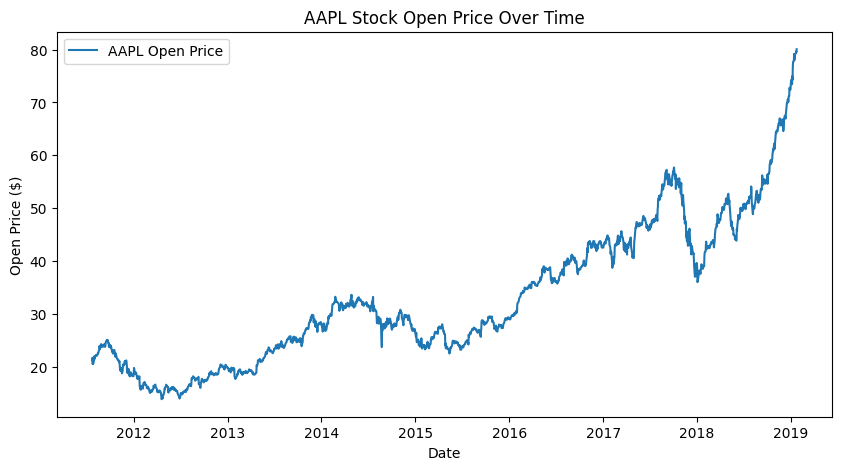

In [137]:
plt.figure(figsize=(10, 5))
plt.plot(daily_data_BERT['Date'], daily_data_BERT['Open'], label='AAPL Open Price')
plt.xlabel('Date')
plt.ylabel('Open Price ($)')
plt.title('AAPL Stock Open Price Over Time')
plt.legend()
plt.show()

In [138]:
daily_data_BERT.to_csv('./data/dataset_for_model.csv')

# Part 2: Stock price prediction

In [206]:
import pandas as pd
daily_data_BERT = pd.read_csv('./data/dataset_for_model.csv', index_col=0)

In [223]:
# 选择特征和目标
# 保留原本的index，将'Date'列单独提取出来保存
date = daily_data_BERT['Date']
date = pd.to_datetime(date)

features = daily_data_BERT.drop(['Date','P_news_pos', 'P_news_neg', 'P_op_pos', 'P_op_neg'], axis=1)
# Open作为预测目标
target = daily_data_BERT['Open']
features.tail()

,Open,High,Low,Close,Adj Close,Volume
1884,79.067497,79.684998,78.750000,79.682503,77.629234,137816400
1885,79.297501,79.754997,79.000000,79.142502,77.103172,110843200
1886,79.644997,79.997498,79.327499,79.425003,77.378380,101832400
1887,79.480003,79.889999,78.912498,79.807503,77.751030,104472000
1888,80.062500,80.832497,79.379997,79.577499,77.526955,146537600


In [208]:
target.tail()

1884    79.067497
1885    79.297501
1886    79.644997
1887    79.480003
1888    80.062500
Name: Open, dtype: float64

In [209]:
# normalization
from sklearn.preprocessing import MinMaxScaler

# Apply the MinMaxScaler to the features and target
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

# fit_transform根据数据计算缩放参数
scaled_features = scaler_features.fit_transform(features)
scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))

# 保存缩放参数
import joblib
joblib.dump(scaler_features, './model/scaler_features.pkl')
joblib.dump(scaler_target, './model/scaler_target.pkl')

# Create new DataFrames with the scaled features and target
scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)
scaled_target_df = pd.DataFrame(scaled_target, columns=['Open'])

In [210]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.dates as mdates

In [211]:
def create_sequences(features, targets, seq_length):
    """
    Create sequences of specified length from time series data.

    Args:
    features (np.array): The feature data.
    targets (np.array): The target data.
    seq_length (int): The length of the sequence.

    Returns:
    np.array: Sequences of features.
    np.array: Corresponding targets for each sequence.
    """
    xs, ys = [], []
    for i in range(len(features) - seq_length):
        x = features[i:(i + seq_length)]
        y = targets[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [212]:
# Example sequence length
seq_length = 25

# Create sequences
features_seq, target_seq = create_sequences(scaled_features, scaled_target, seq_length)


1. train_test_split随机划分

In [213]:
train_features, test_features, train_target, test_target = train_test_split(
    features_seq, target_seq, test_size=0.2, random_state=42
)

val_features, test_features, val_target, test_target = train_test_split(
    test_features, test_target, test_size=0.5, random_state=42
)

2. 按时间顺序划分

In [197]:
# 计算训练集、验证集、测试集的大小
train_size = int(len(features_seq) * 0.8)
val_size = int(len(features_seq) * 0.15)
test_size = len(features_seq) - train_size - val_size

# 按时间顺序划分训练集、验证集、测试集
train_features, train_target = features_seq[:train_size], target_seq[:train_size]
val_features, val_target = features_seq[train_size:train_size+val_size], target_seq[train_size:train_size+val_size]
test_features, test_target = features_seq[train_size+val_size:], target_seq[train_size+val_size:]

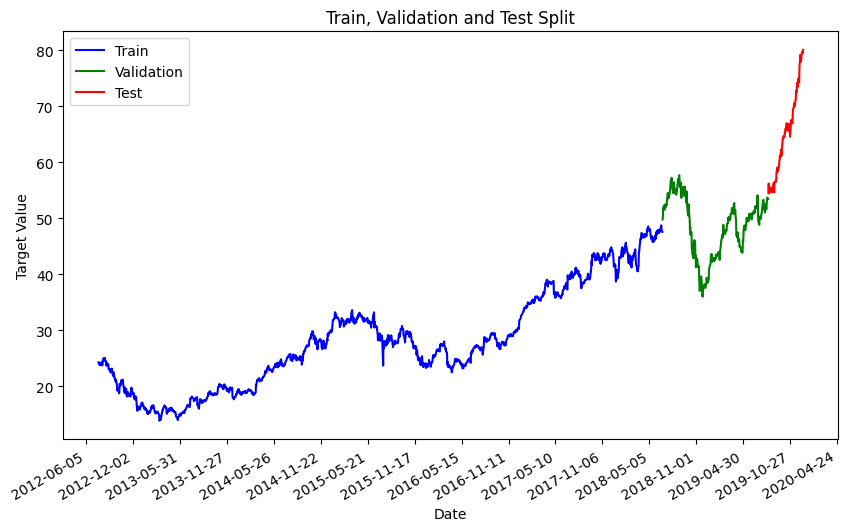

In [198]:
# 假设我们的目标是预测第一个特征
train_target_unscaled = scaler_target.inverse_transform(train_target)
val_target_unscaled = scaler_target.inverse_transform(val_target)
test_target_unscaled = scaler_target.inverse_transform(test_target)

plt.figure(figsize=(10, 6))

# 将日期字符串转换为日期对象
date = pd.to_datetime(date)

# 绘制训练集
plt.plot(date[:train_size], train_target_unscaled, color='blue', label='Train')

# 绘制验证集
plt.plot(date[train_size:train_size+val_size], val_target_unscaled, color='green', label='Validation')

# 绘制测试集
plt.plot(date[train_size+val_size:train_size+val_size+len(test_target_unscaled)], test_target_unscaled, color='red', label='Test')

# 设置x轴的日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=180))  # 设置日期间隔，这里是每250天一个刻度

plt.title('Train, Validation and Test Split')
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.legend()
plt.gcf().autofmt_xdate()  # 自动调整x轴日期标签的角度以提高可读性
plt.show()

- 准备训练

In [214]:
# Convert sequences to Tensor
train_features = torch.tensor(train_features, dtype=torch.float32)
train_target = torch.tensor(train_target, dtype=torch.float32)

val_features = torch.tensor(val_features, dtype=torch.float32)
val_target = torch.tensor(val_target, dtype=torch.float32)

test_features = torch.tensor(test_features, dtype=torch.float32)
test_target = torch.tensor(test_target, dtype=torch.float32)

# 创建TensorDataset
train_dataset = TensorDataset(train_features, train_target)
val_dataset = TensorDataset(val_features, val_target)
test_dataset = TensorDataset(test_features, test_target)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [215]:
# 使用普通的LSTM模型，不使用注意力机制
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, output_dim, dropout=0.2):
        super(SimpleLSTM, self).__init__()
        self.hidden_size = hidden_size

        # LSTM层
        self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, 
                            batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
        # 全连接层
        self.fc = nn.Linear(hidden_size, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # 打印lstm_out的形状
        # print(lstm_out.shape)
        # 取最后一个时间步的输出
        output = self.fc(lstm_out[:, -1, :])
        return output

In [216]:
# # 使用注意力机制的LSTM
# class Attention(nn.Module):
#     def __init__(self, hidden_size):
#         super(Attention, self).__init__()
#         self.hidden_size = hidden_size
#         self.attn = nn.Linear(self.hidden_size, 1)

#     def forward(self, hidden, encoder_outputs):
#         attn_weights = torch.tanh(self.attn(encoder_outputs))
#         return torch.bmm(attn_weights.transpose(1, 2), encoder_outputs).squeeze(1)

# class AttentionLSTM(nn.Module):
#     def __init__(self, input_dim, hidden_size, num_layers, output_dim, dropout=0.2):
#         super(AttentionLSTM, self).__init__()
#         self.hidden_size = hidden_size

#         # LSTM层
#         self.lstm = nn.LSTM(input_dim, hidden_size, num_layers, 
#                             batch_first=True, dropout=dropout if num_layers > 1 else 0)
        
#         # 注意力层
#         self.attention = Attention(hidden_size)
        
#         # 全连接层
#         self.fc = nn.Linear(hidden_size, output_dim)

#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         attn_out = self.attention(lstm_out[:, -1, :], lstm_out)
#         output = self.fc(attn_out)
#         return output

In [217]:
# 超参数
input_dim = scaled_features_df.shape[1]  # 特征数量
hidden_size = 100  # 隐藏状态中的特征数量，可以调整
num_layers = 4    # 堆叠的LSTM层的数量
output_dim = 1    # 输出维度的数量（预测一个值）

# 使用SimpleLSTM
model = SimpleLSTM(input_dim, hidden_size, num_layers, output_dim, dropout=0.2)
# 使用AttentionLSTM
# model = AttentionLSTM(input_dim, hidden_size, num_layers, output_dim, dropout=0.2)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_model updated at epoch 1, best_val_loss : 0.0023
Epoch 1/50, Train Loss: 0.0202, Validation Loss: 0.0023
best_model updated at epoch 2, best_val_loss : 0.0003
Epoch 6/50, Train Loss: 0.0006, Validation Loss: 0.0005
best_model updated at epoch 8, best_val_loss : 0.0002
Epoch 11/50, Train Loss: 0.0004, Validation Loss: 0.0003
best_model updated at epoch 12, best_val_loss : 0.0002
best_model updated at epoch 15, best_val_loss : 0.0002
Epoch 16/50, Train Loss: 0.0004, Validation Loss: 0.0002
Epoch 21/50, Train Loss: 0.0003, Validation Loss: 0.0004
best_model updated at epoch 24, best_val_loss : 0.0002
best_model updated at epoch 26, best_val_loss : 0.0001
Epoch 26/50, Train Loss: 0.0003, Validation Loss: 0.0001
best_model updated at epoch 29, best_val_loss : 0.0001
Epoch 31/50, Train Loss: 0.0003, Validation Loss: 0.0002
best_model updated at epoch 36, best_val_loss : 0.0001
Epoch 36/50, Train Loss: 0.0002, Validation Loss: 0.0001
best_model updated at epoch 38, best_val_loss : 0.0001

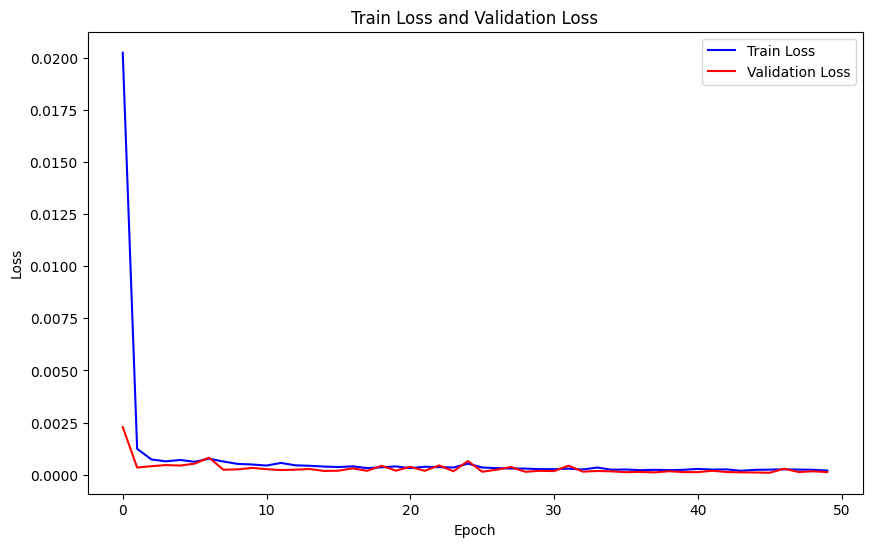

In [218]:
# 训练模型
num_epochs = 50
best_val_loss = float('inf')
train_loss_list = []
val_loss_list = []
for epoch in range(num_epochs):
    model.train()
    train_losses = []
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    model.eval()
    val_losses = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './model/best_model.pth')
        print('best_model updated at epoch {}, best_val_loss : {:.4f}'.format(epoch+1, best_val_loss))
        
    # 每5轮打印一次train loss和val loss
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    # 记录两个loss
    train_loss_list.append(train_loss)
    val_loss_list.append(val_loss)
    
# 在所有epochs结束后绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_loss_list, label='Train Loss', color='blue')
plt.plot(range(num_epochs), val_loss_list, label='Validation Loss', color='red')
plt.title('Train Loss and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


0. 简单LSTM网络

The date range of the new test set is from 2019-09-12 00:00:00 to 2020-01-24 00:00:00
The length is 93


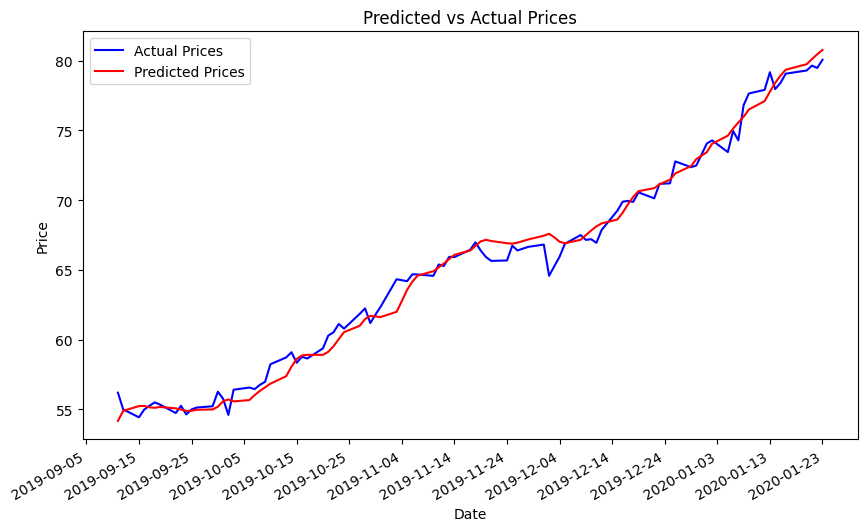

In [224]:
# 加载最佳模型
model.load_state_dict(torch.load('./model/best_model.pth'))

# 计算新的测试集的大小
test_size_new = int(len(features_seq) * 0.05)

# 按时间顺序划分新的测试集
test_features_new, test_target_new = features_seq[-test_size_new:], target_seq[-test_size_new:]

# 使用模型进行预测
model.eval()
with torch.no_grad():
    test_predictions_new = model(torch.tensor(test_features_new, dtype=torch.float32)).numpy()

# 反缩放预测值
test_predictions_new = scaler_target.inverse_transform(test_predictions_new).flatten()

# 反缩放真实目标值
test_target_new = scaler_target.inverse_transform(test_target_new.reshape(-1, 1)).flatten()

# 计算日期的总长度
total_length = len(date)

# 计算测试集的开始位置
test_start = total_length - test_size_new

# 计算新的测试集的结束位置
test_end = total_length

# 获取新的测试集的日期范围
test_date_new = date[test_start:test_end]

# Print the date range of the new test set
print("The date range of the new test set is from", test_date_new.iloc[0], "to", test_date_new.iloc[-1])

# Print the length of the new test set
print("The length is", len(test_target_new))

# 绘制实际股价和预测股价的对比图
plt.figure(figsize=(10, 6))
plt.plot(date[test_start:], test_target_new, label='Actual Prices', color='blue')
plt.plot(date[test_start:], test_predictions_new, label='Predicted Prices', color='red')

# 设置x轴的日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # 设置日期间隔

plt.title('Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()  # 自动调整x轴日期标签的角度以提高可读性
plt.show()

In [220]:
from sklearn.metrics import mean_squared_error

# 计算MSE
mse = mean_squared_error(test_target_new, test_predictions_new)
print('Test MSE: ', mse)
# 计算RMSE
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

Test MSE:  0.7102671065265816
Test RMSE:  0.8427734609766623


1. 对应随机划分：另行画5%

新的测试集的日期范围是从 2019-09-12 00:00:00 到 2020-01-24 00:00:00
长度是 93


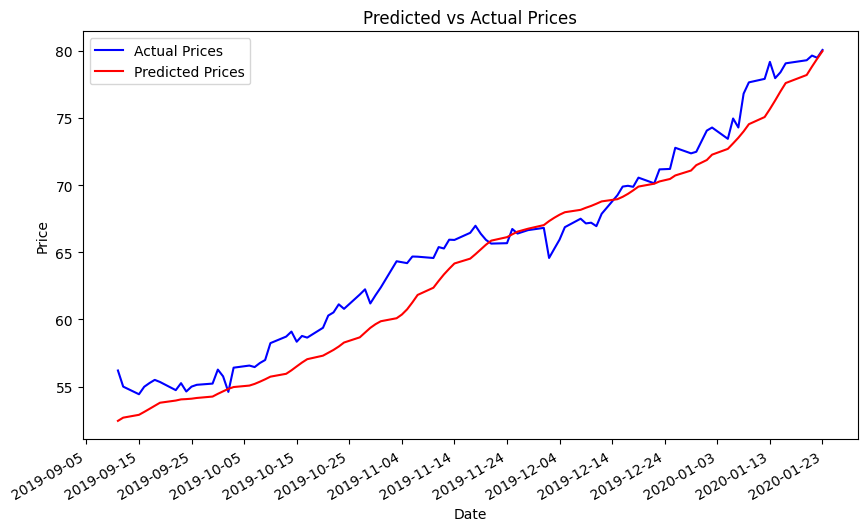

In [187]:
# 加载最佳模型
model.load_state_dict(torch.load('./model/best_model.pth'))

# 计算新的测试集的大小
test_size_new = int(len(features_seq) * 0.05)

# 按时间顺序划分新的测试集
test_features_new, test_target_new = features_seq[-test_size_new:], target_seq[-test_size_new:]

# 使用模型进行预测
model.eval()
with torch.no_grad():
    test_predictions_new = model(torch.tensor(test_features_new, dtype=torch.float32)).numpy()

# 反缩放预测值
test_predictions_new = scaler_target.inverse_transform(test_predictions_new).flatten()

# 反缩放真实目标值
test_target_new = scaler_target.inverse_transform(test_target_new.reshape(-1, 1)).flatten()

# 计算日期的总长度
total_length = len(date)

# 计算测试集的开始位置
test_start = total_length - test_size_new

# 计算新的测试集的结束位置
test_end = total_length

# 获取新的测试集的日期范围
test_date_new = date[test_start:test_end]

# Print the date range of the new test set
print("The date range of the new test set is from", test_date_new.iloc[0], "to", test_date_new.iloc[-1])

# Print the length of the new test set
print("The length is", len(test_target_new))

# 绘制实际股价和预测股价的对比图
plt.figure(figsize=(10, 6))
plt.plot(date[test_start:], test_target_new, label='Actual Prices', color='blue')
plt.plot(date[test_start:], test_predictions_new, label='Predicted Prices', color='red')

# 设置x轴的日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # 设置日期间隔

plt.title('Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()  # 自动调整x轴日期标签的角度以提高可读性
plt.show()

In [189]:
from sklearn.metrics import mean_squared_error

# 计算MSE
mse = mean_squared_error(test_target_new, test_predictions_new)
print('Test MSE: ', mse)
# 计算RMSE
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

Test MSE:  3.7595829445397633
Test RMSE:  1.9389644000186705


2. 对应顺序划分：直接用Test集

/tmp/ipykernel_27489/3177828324.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = model(torch.tensor(test_features, dtype=torch.float32)).numpy()


The date range of the test set is from 2019-09-11 00:00:00 to 2020-01-24 00:00:00
The length is 94


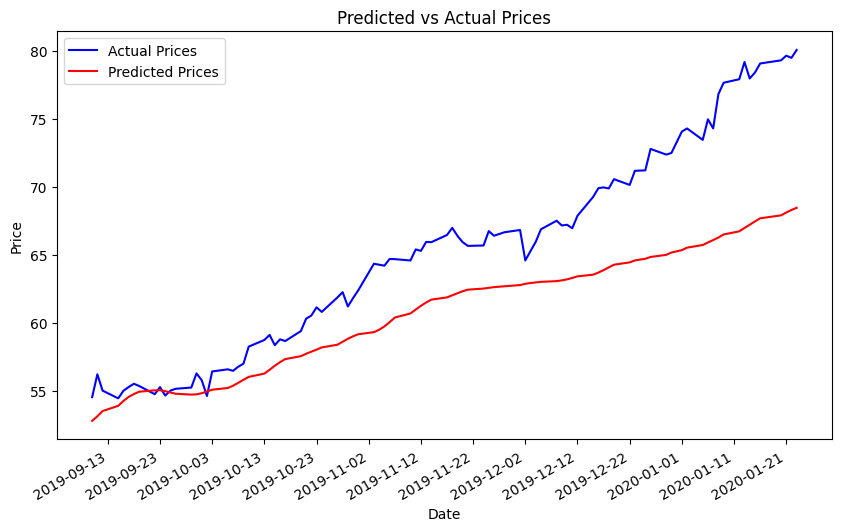

In [204]:
# 加载最佳模型
model.load_state_dict(torch.load('./model/best_model.pth'))

# 使用模型进行预测
model.eval()
with torch.no_grad():
    test_predictions = model(torch.tensor(test_features, dtype=torch.float32)).numpy()

# 反缩放预测值
test_predictions = scaler_target.inverse_transform(test_predictions).flatten()

# 反缩放真实目标值
test_target = scaler_target.inverse_transform(test_target.reshape(-1, 1)).flatten()

# 计算日期的总长度
total_length = len(date)

# 计算测试集的开始位置
test_start = total_length - test_size

# 计算新的测试集的结束位置
test_end = total_length

# 获取新的测试集的日期范围
test_date = date[test_start:test_end]

print("The date range of the test set is from", test_date.iloc[0], "to", test_date.iloc[-1])
print("The length is", len(test_target))

# 绘制实际股价和预测股价的对比图
plt.figure(figsize=(10, 6))
plt.plot(date[test_start:], test_target, label='Actual Prices', color='blue')
plt.plot(date[test_start:], test_predictions, label='Predicted Prices', color='red')

# 设置x轴的日期格式
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))  # 设置日期间隔

plt.title('Predicted vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()  # 自动调整x轴日期标签的角度以提高可读性
plt.show()

In [205]:
from sklearn.metrics import mean_squared_error

# 计算MSE
mse = mean_squared_error(test_target, test_predictions)
print('Test MSE: ', mse)
# 计算RMSE
rmse = np.sqrt(mse)
print('Test RMSE: ', rmse)

Test MSE:  30.260619498164488
Test RMSE:  5.500965324210332
